In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Kaggle com os datasets que eu peguei<BR>
https://www.kaggle.com/datasets/davidcariboo/player-scores?resource=download&select=clubs.csv

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving clubs.csv to clubs.csv


#Modelagem os dados

In [ ]:
dftransfer = pd.read_csv('/content/transfers.csv')
dfclubs= pd.read_csv('/content/clubs.csv')
dfplayer= pd.read_csv('/content/players.csv')

In [ ]:
# Merge liga de origem
df = dftransfer.merge(
    dfclubs[['club_id', 'domestic_competition_id']],
    left_on='from_club_id',
    right_on='club_id',
    how='left'
).rename(columns={'domestic_competition_id': 'from_league'}).drop(columns=['club_id'])

# Merge liga de destino
df = df.merge(
    dfclubs[['club_id', 'domestic_competition_id']],
    left_on='to_club_id',
    right_on='club_id',
    how='left'
).rename(columns={'domestic_competition_id': 'to_league'}).drop(columns=['club_id'])

# Merge dados pessoais do jogador
df = df.merge(
    dfplayer[['player_id','date_of_birth','country_of_citizenship','sub_position']],
    on='player_id',
    how='left'
)


Mudando o nome da coluna sub_position para player_pos

In [ ]:
df.rename(columns={"sub_position":"player_pos"},inplace=True)

Modificação dos nomes das ligas para o nome tradicional

In [ ]:
df.replace({'to_league':{"GB1":"Premier League"}},inplace=True)
df.replace({'to_league':{"ES1":"La liga"}},inplace=True)
df.replace({'to_league':{"IT1":"Serie A"}},inplace=True)
df.replace({'to_league':{"L1":"Bundesliga"}},inplace=True)
df.replace({'to_league':{"FR1":"League One"}},inplace=True)
df.replace({'to_league':{"PO1":"Liga Portugal"}},inplace=True)
df.replace({'to_league':{"NL1":"Eredivisie"}},inplace=True)

df.replace({'from_league':{"GB1":"Premier League"}},inplace=True)
df.replace({'from_league':{"ES1":"La liga"}},inplace=True)
df.replace({'from_league':{"IT1":"Serie A"}},inplace=True)
df.replace({'from_league':{"L1":"Bundesliga"}},inplace=True)
df.replace({'from_league':{"FR1":"League One"}},inplace=True)
df.replace({'from_league':{"PO1":"Liga Portugal"}},inplace=True)
df.replace({'from_league':{"NL1":"Eredivisie"}},inplace=True)

Criação da coluna idade, para saber quantos anos o jogador tinha na epoca da transferencia

In [ ]:
df["date_of_birth"] = pd.to_datetime(df["date_of_birth"])
df["transfer_date"] = pd.to_datetime(df["transfer_date"])
df["player_age"] = (df["transfer_date"] - df["date_of_birth"]).dt.days // 365

Criação de uma nova coluna para caracterizar e agrupar o jogador de acordo com a idade

In [ ]:
def classificacao_idade(player_age:int):
    if player_age <= 20: return "Promesa"
    elif player_age > 20 and player_age <= 24 : return "Tem potencial"
    elif player_age > 24 and player_age <= 28 : return "Auge"
    elif player_age > 28 and player_age <= 32 : return "Joga em alto nivel"
    else: return "Fim de carreira"

In [ ]:
df["age_class"] = df["player_age"].apply(classificacao_idade)

Criação da coluna window, para saber em qual janela a transferencia foi feita

In [ ]:
month = df["transfer_date"].dt.month
year = df["transfer_date"].dt.year

conditions = [
    (year.isin([2026])), # ano ainda não chegou
    (month.isin([6, 7, 8])),
    (month.isin([1, 2]))
]

choices = [
    "pre-contract",
    "winter",
    "summer"
]

df["window"] = np.select(conditions, choices, default="pre-contract")


Matendo somente as compras das top 7 ligas europeias

In [ ]:
df = df[~df["to_league"].isin(["BE1", "SC1","GR1","TR1","UKR1","SC1","RU1","DK1"])]

Modificação das vendas de clubes que estão fora do top7 ligas europeias para ligas alternativas<br><b>

In [ ]:
ligas_alvo = ["BE1", "SC1", "GR1", "TR1", "UKR1", "RU1", "DK1"]

df.loc[
    (
        (df["from_league"].isna() | (df["from_league"].str.strip() == "")) &
        (~df["from_club_name"].isna() & (df["from_club_name"].str.strip() != ""))
    )
    | (df["from_league"].isin(ligas_alvo)),
    "from_league"
] = "Alternative league"


#Tratamento dos dados

Foi feita uma analise e foi percebido que as idades de até 15 anos tinham muitas vezes suas ligas de compra em branco, portanto foram retirados do dataset, as outras foram analisadas mais aprofundadas e o resultado é mostrando mais a frente

In [ ]:
df["to_league_null"] = df["to_league"].isna()

resultado = df.groupby(["player_age", "to_league_null"]).size().unstack(fill_value=0)

print(resultado)


to_league_null  False  True 
player_age                  
4.0                 0      3
5.0                 0      5
6.0                 0     34
7.0                 0     94
8.0                 0    146
9.0                 0    169
10.0                0    262
11.0                0    369
12.0                0    553
13.0                0    796
14.0                0   1335
15.0                5   2826
16.0               91   5051
17.0              464   5625
18.0             1350   5240
19.0             2220   4612
20.0             2580   3869
21.0             2756   3237
22.0             2616   2329
23.0             2273   1652
24.0             1910   1196
25.0             1549    849
26.0             1224    674
27.0             1056    497
28.0              752    411
29.0              570    346
30.0              427    267
31.0              299    225
32.0              216    158
33.0              133    116
34.0               82     97
35.0               70     74
36.0          

In [ ]:
df = df.drop(df[(df["player_age"].between(1, 15)) & (df["to_league"].isna())].index)

Mudando as linhas vazias das colunas from_league e to_leauge para casos de Agente livre ou de aposentadoria

In [ ]:
df.loc[
    df["from_club_name"].isin(["Retired", "Without Club"]),
    "from_league"
] = "Without league"

df.loc[
    df["to_club_name"].isin(["Retired", "Without Club"]),
    "to_league"
] = "Without league"

Trocar as posiçoes para sigla em portugues

In [ ]:
df.replace({'player_pos':{"Goalkeeper":"GOL"}},inplace=True)
df.replace({'player_pos':{"Centre-Back":"ZAG"}},inplace=True)
df.replace({'player_pos':{"Left-Back":"LE"}},inplace=True)
df.replace({'player_pos':{"Defensive Midfield":"VOL"}},inplace=True)
df.replace({'player_pos':{"Left Midfield":"ME"}},inplace=True)
df.replace({'player_pos':{"Left Winger":"PE"}},inplace=True)
df.replace({'player_pos':{"Right-Back":"LD"}},inplace=True)
df.replace({'player_pos':{"Right Midfield":"MD"}},inplace=True)
df.replace({'player_pos':{"Right Winger":"PD"}},inplace=True)
df.replace({'player_pos':{"Attacking Midfield":"MEI"}},inplace=True)
df.replace({'player_pos':{"Second Striker":"SA"}},inplace=True)
df.replace({'player_pos':{"Centre-Forward":"ATA"}},inplace=True)
df.replace({'player_pos':{"Central Midfield":"MC"}},inplace=True)

Retirar jogadores com idades em branco

In [ ]:
df=df.dropna(subset=['date_of_birth'])

Retirar os jogadores que sairam para clubes fora do top7 ligas europeias

In [ ]:
df=df.dropna(subset=['to_league'])

Retira jogadores de posicionamento vazia

In [ ]:
df=df.dropna(subset=['player_pos'])

Retirando temporadas que não possuem dados relevante, muitos dados vazios em relação a preços de compras e valor de mercado do jogador

In [ ]:
df_teste = df.copy()

df_teste['em_branco'] = df_teste['market_value_in_eur'].isna() | (df_teste['market_value_in_eur'] == '')

resumo = df_teste.groupby('transfer_season')['em_branco'].agg(
    total='count',
    brancos='sum'
)

# Criar coluna com % de brancos
resumo['perc_brancos'] = (resumo['brancos'] / resumo['total']) * 100

print(resumo.sort_values('brancos', ascending=False))


                 total  brancos  perc_brancos
transfer_season                              
20/21             1972      210     10.649087
19/20             1973      188      9.528637
21/22             2293      165      7.195813
23/24             3208      160      4.987531
22/23             2918      154      5.277587
18/19             1659      151      9.101869
24/25             3028      149      4.920740
15/16             1095      140     12.785388
16/17             1215      123     10.123457
13/14              667      120     17.991004
14/15              849      118     13.898704
12/13              493      114     23.123732
17/18             1414      109      7.708628
11/12              451       98     21.729490
10/11              308       80     25.974026
09/10              204       66     32.352941
07/08              128       53     41.406250
08/09              134       44     32.835821
06/07               65       30     46.153846
04/05               23       19   

In [ ]:
df_teste['em_branco'] = df['transfer_fee'].isna() | (df['transfer_fee'] == '')

resumo = df_teste.groupby('transfer_season')['em_branco'].agg(
    total='count',
    brancos='sum'
)

# Criar coluna com % de brancos
resumo['perc_brancos'] = (resumo['brancos'] / resumo['total']) * 100

print(resumo.sort_values('brancos', ascending=False))


                 total  brancos  perc_brancos
transfer_season                              
20/21             5355     2009     37.516340
21/22             5687     1862     32.741340
22/23             6128     1795     29.291775
19/20             5090     1680     33.005894
18/19             4697     1580     33.638493
17/18             4145     1476     35.609168
23/24             6014     1430     23.777852
16/17             3447     1273     36.930664
24/25             4183     1190     28.448482
15/16             3083     1120     36.328252
14/15             2606     1024     39.293937
13/14             2086      873     41.850431
12/13             1733      782     45.124062
11/12             1510      637     42.185430
10/11             1087      512     47.102116
09/10              772      390     50.518135
08/09              533      292     54.784240
07/08              430      223     51.860465
06/07              280      146     52.142857
05/06              189      100   

In [ ]:
temporadas_remover = ['93/94', '94/95', '95/96', '96/97', '97/98', '98/99',
                      '99/00', '00/01', '01/02', '02/03', '03/04']
df = df[~df['transfer_season'].isin(temporadas_remover)]


Apos analise foi identificado valores nulos, entretanto eles eram as tranferencias gratuitas, ou seja agentes livres ou jogadores se aposentando, portanto foi dicidido ao inves de deixa-los como nulos ou apaga-los transforma-los em 0

In [ ]:
cond1 = df['transfer_fee'].isna() & df['to_club_name'].isin(["Retired", "Without Club"])
qtd1 = cond1.sum()

print("Linhas com transfer_fee nulo e to_club_name = Retired ou Without Club:", qtd1)

Linhas com transfer_fee nulo e to_club_name = Retired ou Without Club: 1492


In [ ]:
df["transfer_fee"] = df["transfer_fee"].fillna(0)


Retirando os valores nulos dos valores de mercado e substituindo pela media.Foi utilizado a media pois com certos filtros será possivel destacar a supervalorização de certos jogadores em relaçao a outros

In [ ]:
df['market_value_in_eur'].describe()

,market_value_in_eur
count,2.419700e+04
mean,4.482354e+06
std,7.742521e+06
min,1.000000e+04
25%,5.000000e+05
50%,2.000000e+06
75%,4.482354e+06
max,1.800000e+08


In [ ]:
df["market_value_in_eur"] = df["market_value_in_eur"].fillna(df["market_value_in_eur"].mean())

Retirando jogadores que foram comprados de ligas fora do top7 e vendidos para clubes fora do top 7 que não foram removidos anteriormente por questão de fatores em comum com outras linhas importantes

In [ ]:
df = df.drop(df[(df["to_league"] == "Without league") & (df["from_league"] == "Alternative league")].index)

#Analise exploratoria

##Liga

###Compra

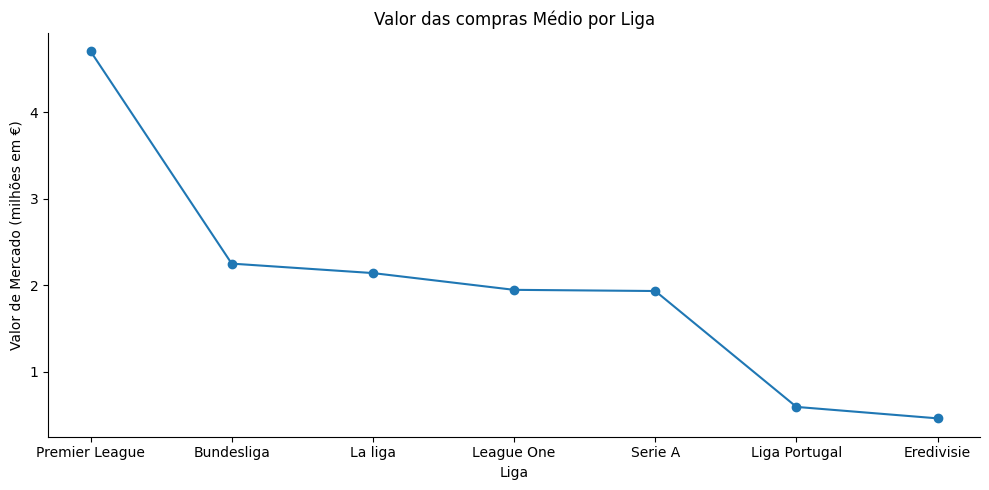

In [ ]:
df_ligas = df[df["to_league"] != "Without league"].groupby("to_league")["transfer_fee"].mean().reset_index()

df_ligas = df_ligas.sort_values("transfer_fee", ascending=False)

df_ligas["transfer_fee"] = df_ligas["transfer_fee"] / 1_000_000

plt.figure(figsize=(10, 5))
plt.plot(df_ligas["to_league"], df_ligas["transfer_fee"], marker="o")

plt.title("Valor das compras Médio por Liga")
plt.xlabel("Liga")
plt.ylabel("Valor de Mercado (milhões em €)")
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()

plt.show()

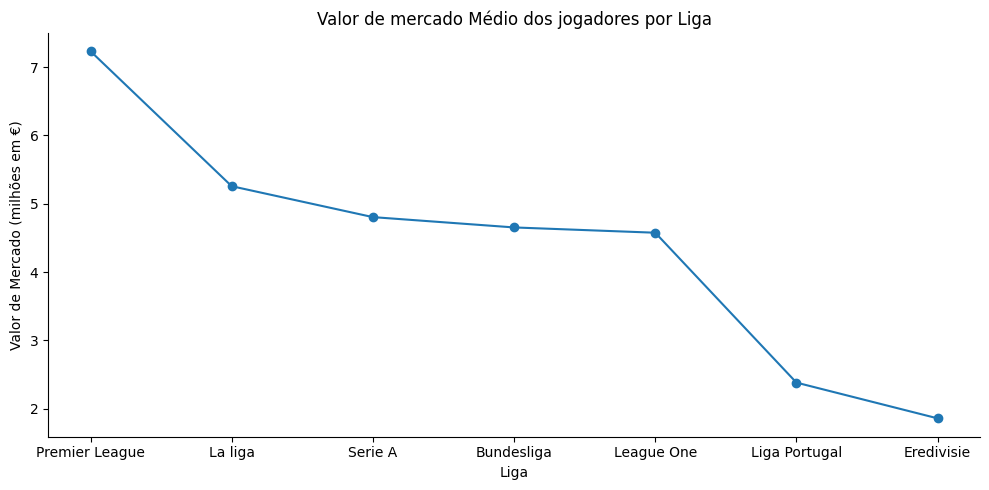

In [ ]:
df_ligas =  df[df["to_league"] != "Without league"].groupby("to_league")["market_value_in_eur"].mean().reset_index()
df_ligas["market_value_in_eur"] = df_ligas["market_value_in_eur"] / 1_000_000

df_ligas = df_ligas.sort_values("market_value_in_eur", ascending=False)

plt.figure(figsize=(10, 5))
plt.plot(df_ligas["to_league"], df_ligas["market_value_in_eur"], marker="o")

plt.title("Valor de mercado Médio dos jogadores por Liga")
plt.xlabel("Liga")
plt.ylabel("Valor de Mercado (milhões em €)")

plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()

plt.show()

###Venda

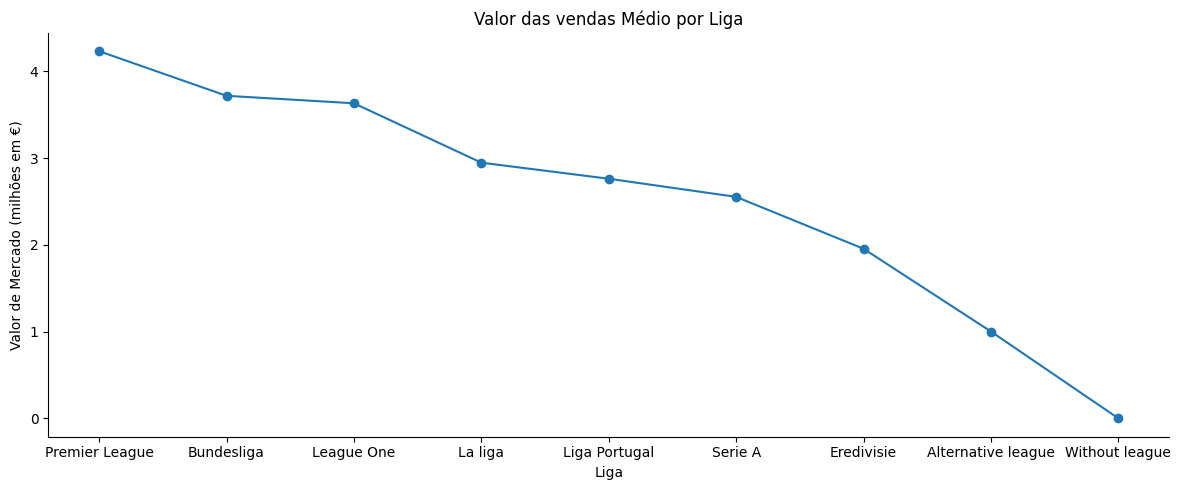

In [ ]:
df_ligas = df.groupby("from_league")["transfer_fee"].mean().reset_index()

df_ligas["transfer_fee"] = df_ligas["transfer_fee"] / 1_000_000
df_ligas = df_ligas.sort_values("transfer_fee", ascending=False)


plt.figure(figsize=(12, 5))
plt.plot(df_ligas["from_league"], df_ligas["transfer_fee"], marker="o")


plt.title("Valor das vendas Médio por Liga")
plt.xlabel("Liga")
plt.ylabel("Valor de Mercado (milhões em €)")


plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()

plt.show()

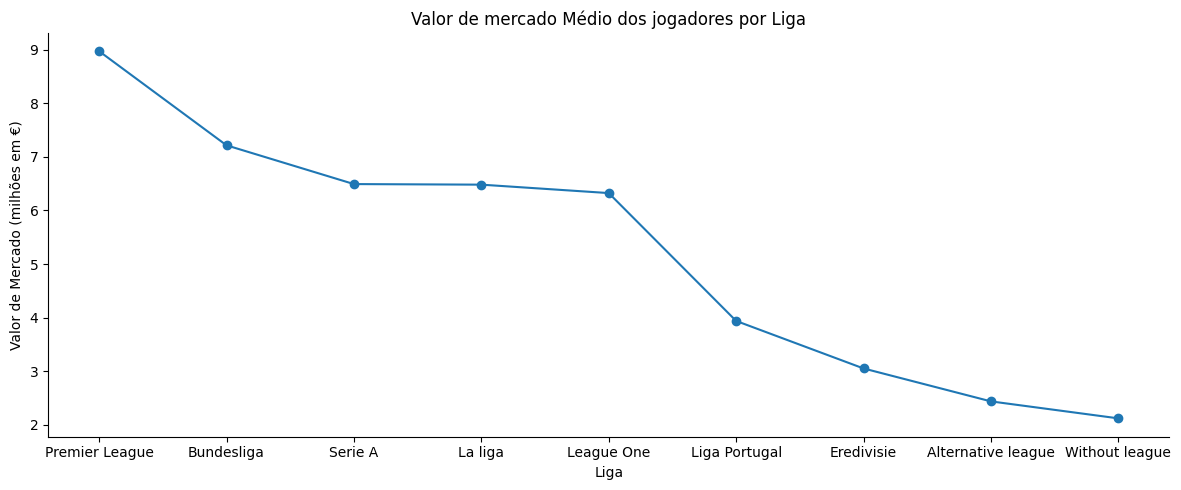

In [ ]:
df_ligas =  df.groupby("from_league")["market_value_in_eur"].mean().reset_index()

df_ligas["market_value_in_eur"] = df_ligas["market_value_in_eur"] / 1_000_000
df_ligas = df_ligas.sort_values("market_value_in_eur", ascending=False)

plt.figure(figsize=(12, 5))
plt.plot(df_ligas["from_league"], df_ligas["market_value_in_eur"], marker="o")

plt.title("Valor de mercado Médio dos jogadores por Liga")
plt.xlabel("Liga")
plt.ylabel("Valor de Mercado (milhões em €)")

plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()

plt.show()

##Posição

<Axes: title={'center': 'Quantidade de jogadores po posição'}, xlabel='Posições'>

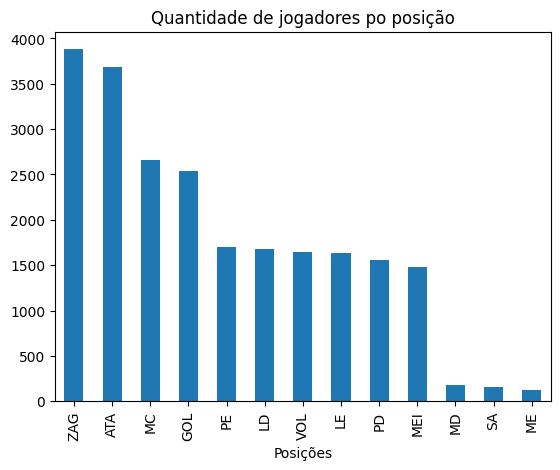

In [ ]:
df["player_pos"].value_counts().plot(kind = "bar",title="Quantidade de jogadores po posição",xlabel="Posições")

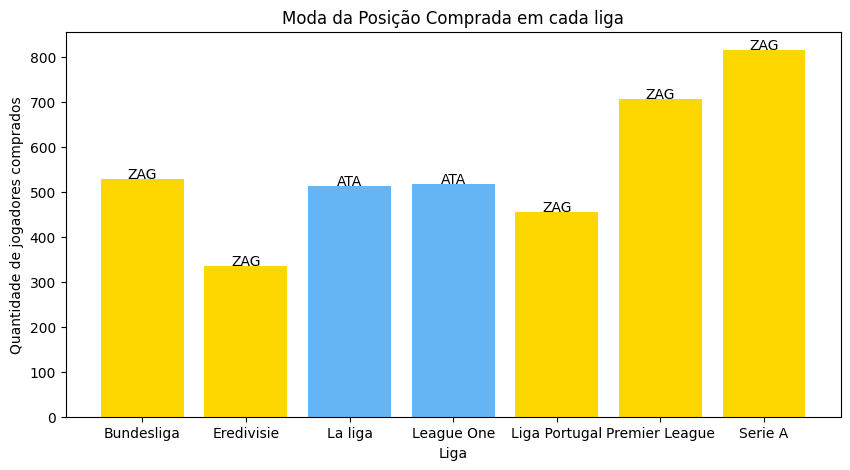

In [ ]:
cores_fifa = {
    "GOL": "#FFA500",
    "ZAG": "#FFD700",
    "LD": "#FFC107",
    "LE": "#FFEB3B",
    "VOL": "#2E7D32",
    "MC": "#4CAF50",
    "ME": "#81C784",
    "MEI": "#66BB6A",
    "MD": "#388E3C",
    "SA": "#0D47A1",
    "ATA": "#64B5F6",
    "PD": "#1E88E5",
    "PE": "#42A5F5",
}

compras = df[df["to_league"] != "Without league"].groupby(["to_league", "player_pos"]).size().reset_index(name="qtd")

mais_compradas = compras.loc[compras.groupby("to_league")["qtd"].idxmax()]

plt.figure(figsize=(10,5))

cores = [cores_fifa[pos] for pos in mais_compradas["player_pos"]]
plt.bar(mais_compradas["to_league"], mais_compradas["qtd"], color=cores)

plt.xlabel("Liga")
plt.ylabel("Quantidade de jogadores comprados")
plt.title("Moda da Posição Comprada em cada liga")

for liga, pos, qtd in zip(mais_compradas["to_league"], mais_compradas["player_pos"], mais_compradas["qtd"]):
    plt.text(liga, qtd+0.5, pos, ha="center")

plt.show()


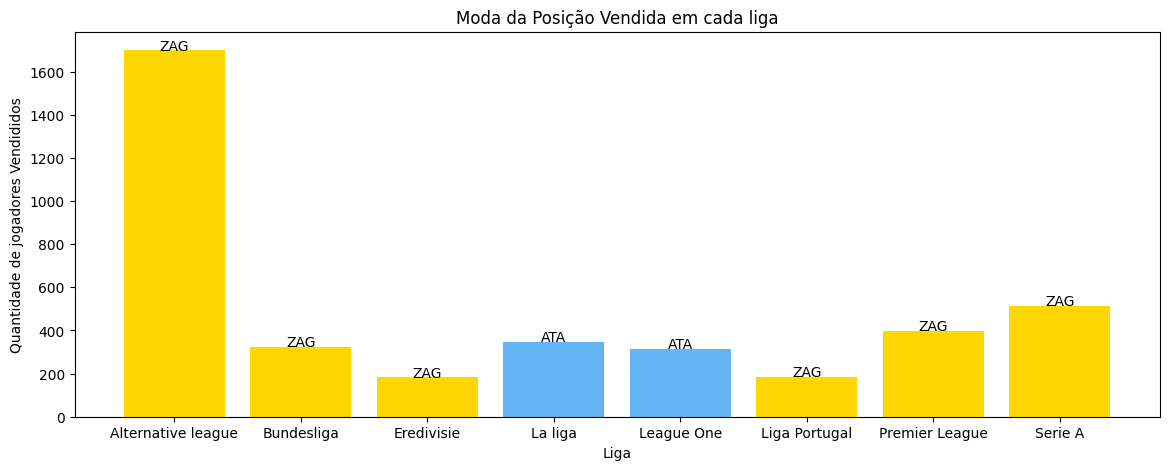

In [ ]:
cores_fifa = {
    "GOL": "#FFA500",
    "ZAG": "#FFD700",
    "LD": "#FFC107",
    "LE": "#FFEB3B",
    "VOL": "#2E7D32",
    "MC": "#4CAF50",
    "ME": "#81C784",
    "MEI": "#66BB6A",
    "MD": "#388E3C",
    "SA": "#0D47A1",
    "ATA": "#64B5F6",
    "PD": "#1E88E5",
    "PE": "#42A5F5",
}

compras = df[df["from_league"] != "Without league"].groupby(["from_league", "player_pos"]).size().reset_index(name="qtd")

mais_compradas = compras.loc[compras.groupby("from_league")["qtd"].idxmax()]

plt.figure(figsize=(14,5))

cores = [cores_fifa[pos] for pos in mais_compradas["player_pos"]]
plt.bar(mais_compradas["from_league"], mais_compradas["qtd"], color=cores)

plt.xlabel("Liga")
plt.ylabel("Quantidade de jogadores Vendididos")
plt.title("Moda da Posição Vendida em cada liga")

for liga, pos, qtd in zip(mais_compradas["from_league"], mais_compradas["player_pos"], mais_compradas["qtd"]):
    plt.text(liga, qtd+0.5, pos, ha="center")

plt.show()


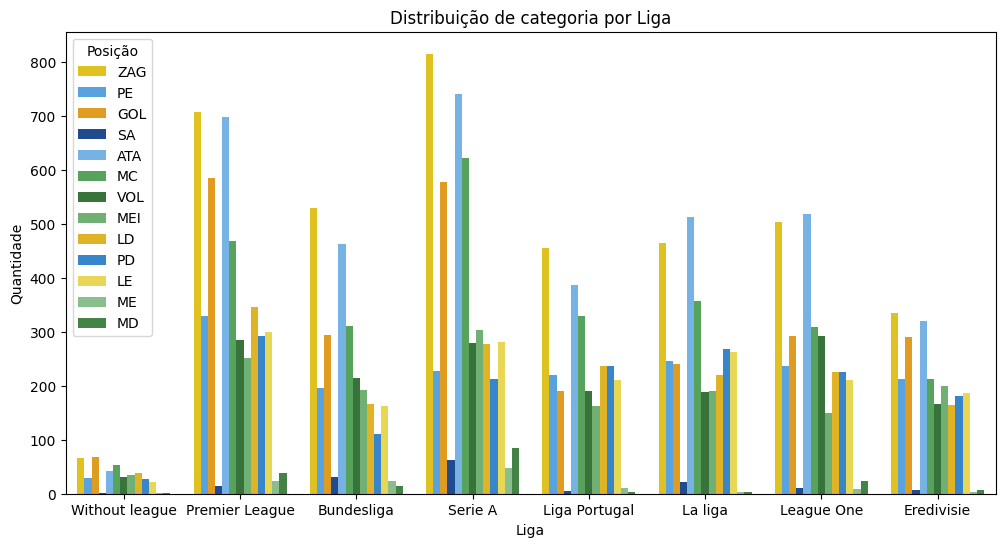

In [ ]:
cores_fifa = {
    "GOL": "#FFA500",
    "ZAG": "#FFD700",
    "LD": "#FFC107",
    "LE": "#FFEB3B",
    "VOL": "#2E7D32",
    "MC": "#4CAF50",
    "ME": "#81C784",
    "MEI": "#66BB6A",
    "MD": "#388E3C",
    "SA": "#0D47A1",
    "ATA": "#64B5F6",
    "PD": "#1E88E5",
    "PE": "#42A5F5",
}

plt.figure(figsize=(12,6))
ax = sns.countplot(
    data=df,
    x="to_league",
    hue="player_pos",
    palette=cores_fifa
)

plt.title("Distribuição de categoria por Liga")
plt.xlabel("Liga")
plt.ylabel("Quantidade")
plt.legend(title="Posição",loc="upper left",)

plt.show()

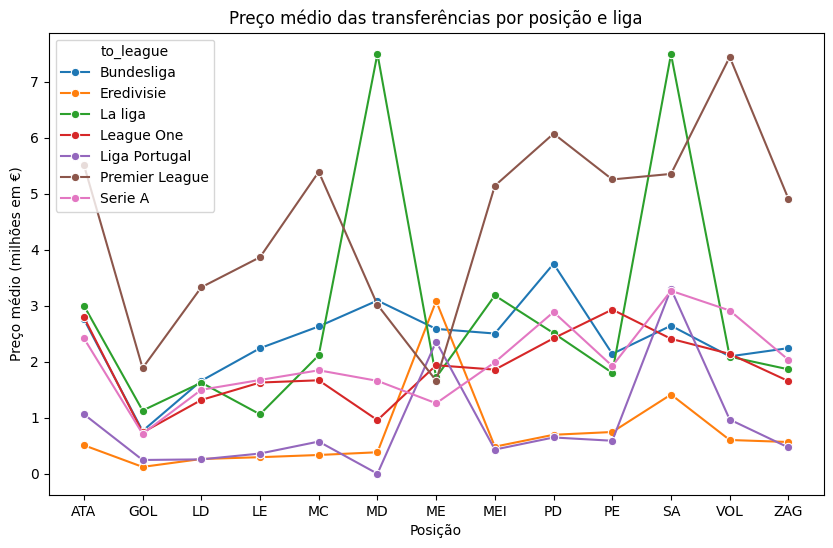

In [ ]:
df_player_league = (
    df[df["to_league"] != "Without league"]
      .groupby(["player_pos", "to_league"])["transfer_fee"]
      .mean()
      .reset_index()
)

df_player_league["transfer_fee"] = df_player_league["transfer_fee"] / 1_000_000

plt.figure(figsize=(10,6))
sns.lineplot(
    data=df_player_league,
    x="player_pos",
    y="transfer_fee",
    hue="to_league",
    marker="o"
)

plt.title("Preço médio das transferências por posição e liga")
plt.xlabel("Posição")
plt.ylabel("Preço médio (milhões em €)")
plt.show()


##Idade

fazer algo com a posição,fazer barras com a quantidade de pessoas que são compradas pela idade,usando a quela ocluna de texto

<Axes: xlabel='player_age'>

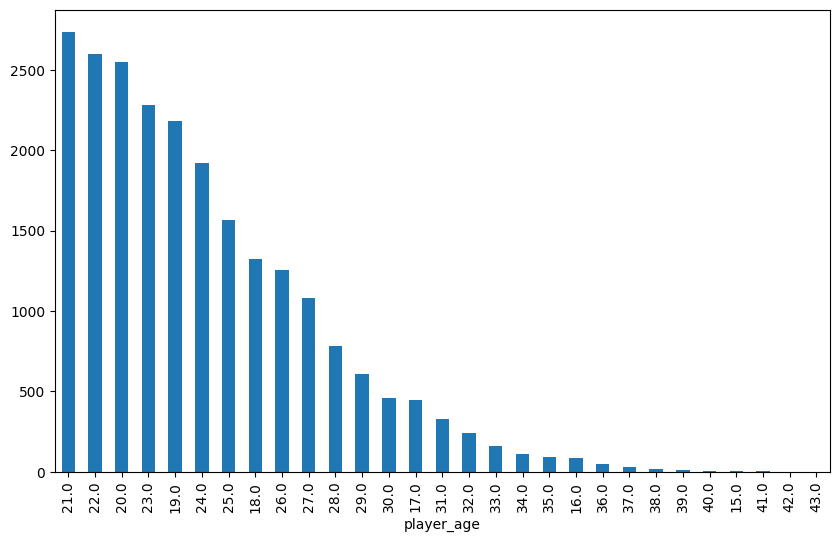

In [ ]:
plt.figure(figsize=(10,6))
df["player_age"].value_counts().plot(kind = "bar")

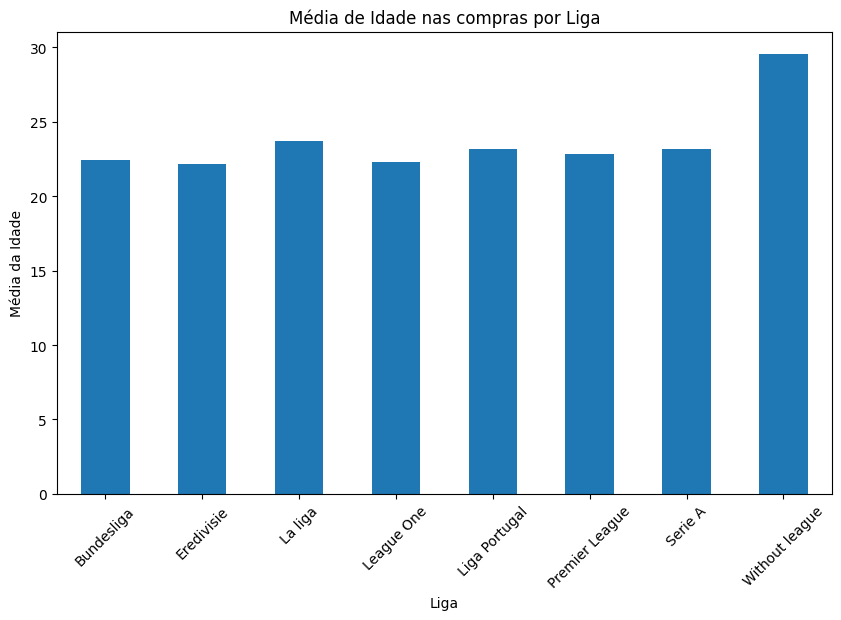

In [ ]:
media_idades = df.groupby("to_league")["player_age"].mean()

plt.figure(figsize=(10,6))
media_idades.plot(kind="bar")
plt.title("Média de Idade nas compras por Liga")
plt.ylabel("Média da Idade")
plt.xlabel("Liga")
plt.xticks(rotation=45)
plt.show()

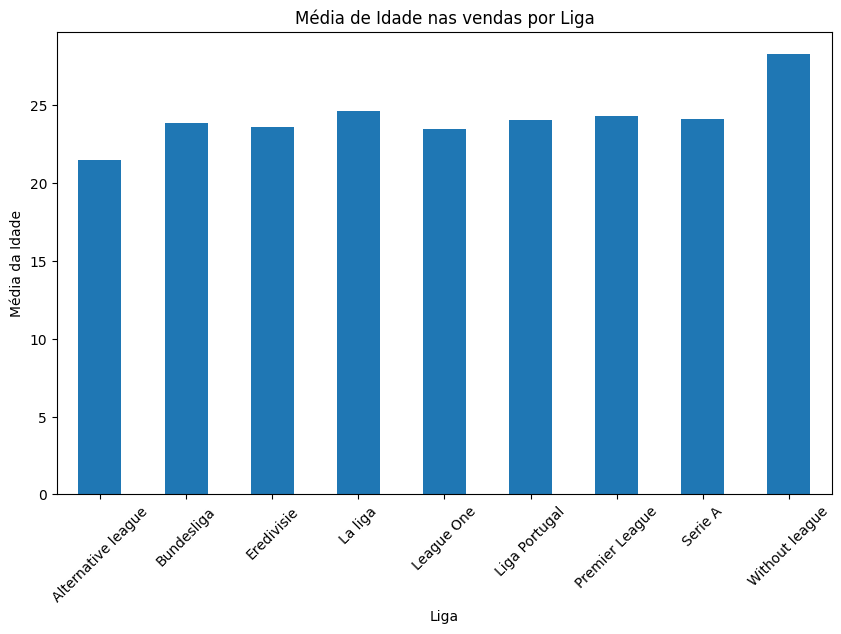

In [ ]:
media_idades = df.groupby("from_league")["player_age"].mean()

plt.figure(figsize=(10,6))
media_idades.plot(kind="bar")
plt.title("Média de Idade nas vendas por Liga")
plt.ylabel("Média da Idade")
plt.xlabel("Liga")
plt.xticks(rotation=45)
plt.show()

<Axes: ylabel='age_class'>

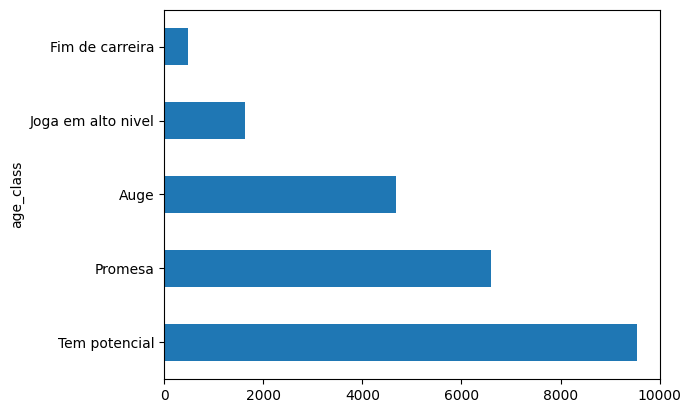

In [ ]:
df["age_class"].value_counts().plot(kind = "barh")

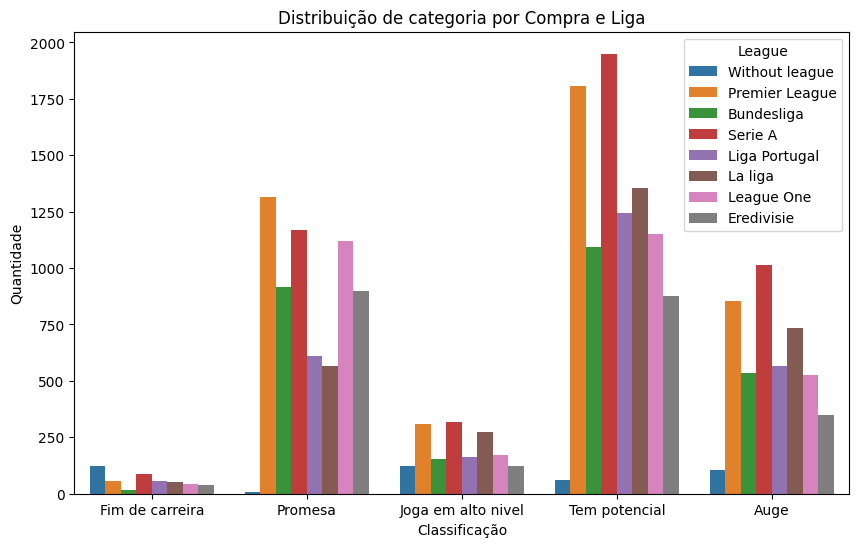

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x="age_class", hue="to_league")

plt.title("Distribuição de categoria por Compra e Liga")
plt.xlabel("Classificação")
plt.ylabel("Quantidade")
plt.legend(title="League")
plt.show()


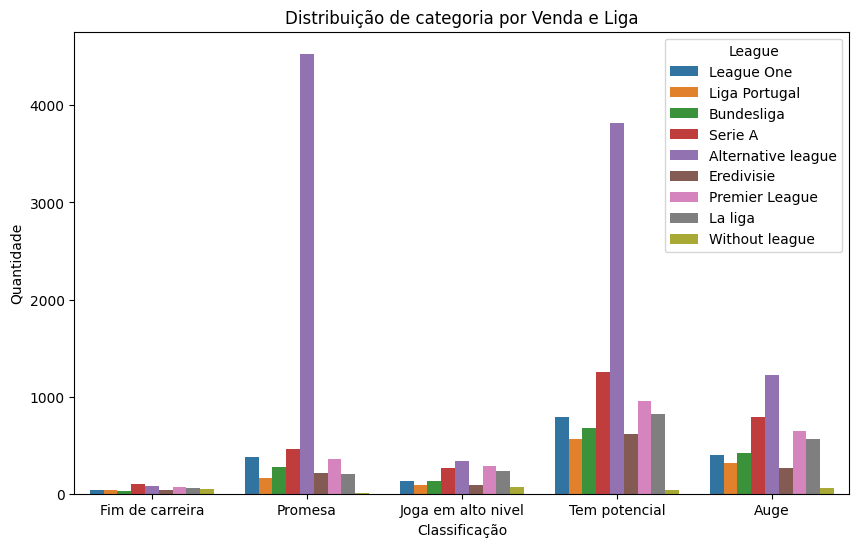

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x="age_class", hue="from_league")

plt.title("Distribuição de categoria por Venda e Liga")
plt.xlabel("Classificação")
plt.ylabel("Quantidade")
plt.legend(title="League")
plt.show()


<Axes: xlabel='player_age', ylabel='player_pos'>

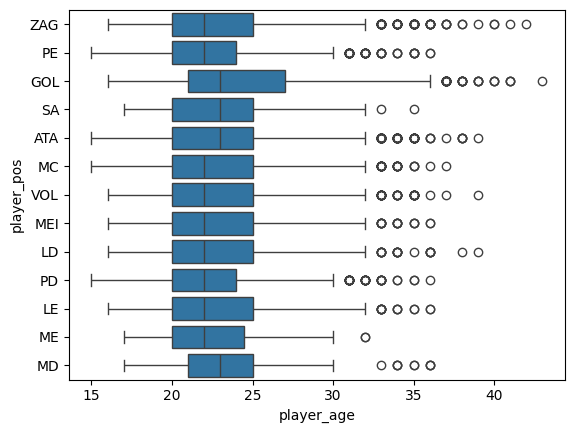

In [ ]:
sns.boxplot(data = df, x = "player_age", y = "player_pos")

<Axes: xlabel='player_age', ylabel='to_league'>

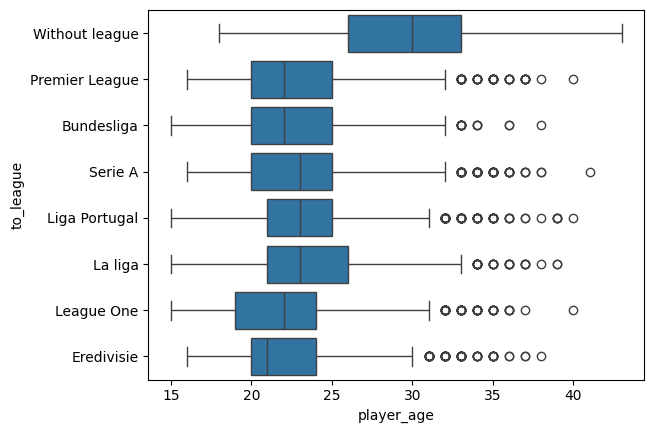

In [ ]:
sns.boxplot(data = df, x = "player_age", y = "to_league")

<Axes: xlabel='player_age', ylabel='from_league'>

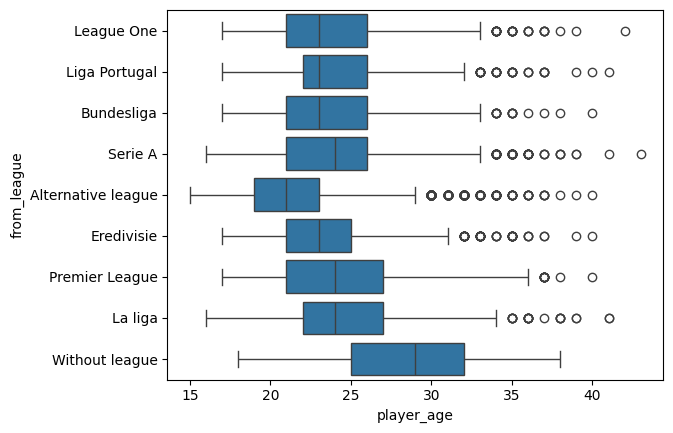

In [ ]:
sns.boxplot(data = df, x = "player_age", y = "from_league")

Janelas

Text(0, 0.5, 'window')

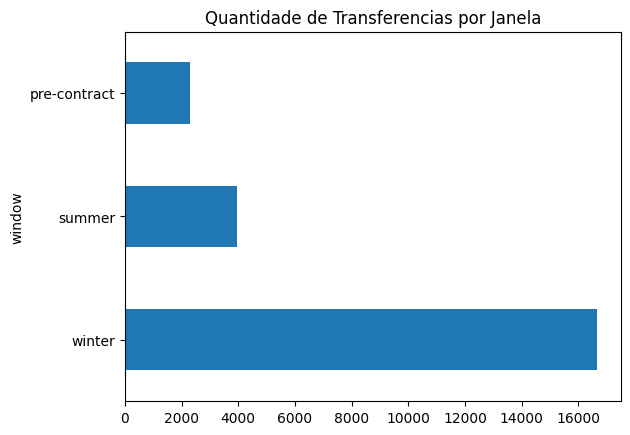

In [ ]:
df["window"].value_counts().plot(kind = "barh")
plt.title("Quantidade de Transferencias por Janela")
plt.xlabel("")
plt.ylabel("window")

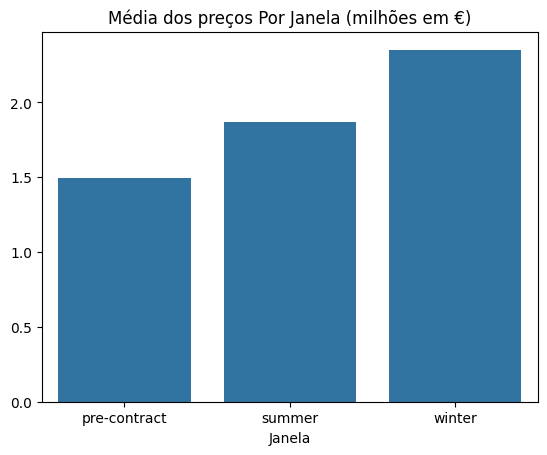

In [ ]:
df_window=df.groupby("window")["transfer_fee"].mean().reset_index()
df_window["transfer_fee"] = df_window["transfer_fee"] / 1_000_000

sns.barplot(data=df_window,x="window",y="transfer_fee")
plt.title("Média dos preços Por Janela (milhões em €)")
plt.xlabel("Janela")
plt.ylabel("")

plt.show()

##Temporada

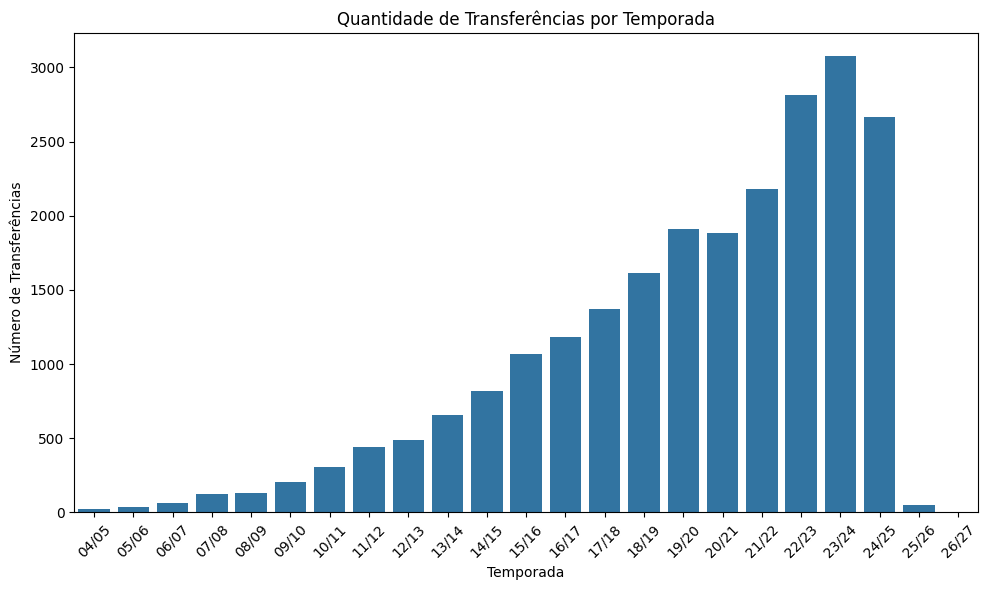

In [ ]:
temporadas_ordenadas = df['transfer_season'].sort_values().unique()
df['transfer_season'] = pd.Categorical(
  df['transfer_season'],categories=temporadas_ordenadas,ordered=True)

plt.figure(figsize=(10,6))
sns.countplot(data=df, x="transfer_season")

plt.title("Quantidade de Transferências por Temporada")
plt.xlabel("Temporada")
plt.ylabel("Número de Transferências")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


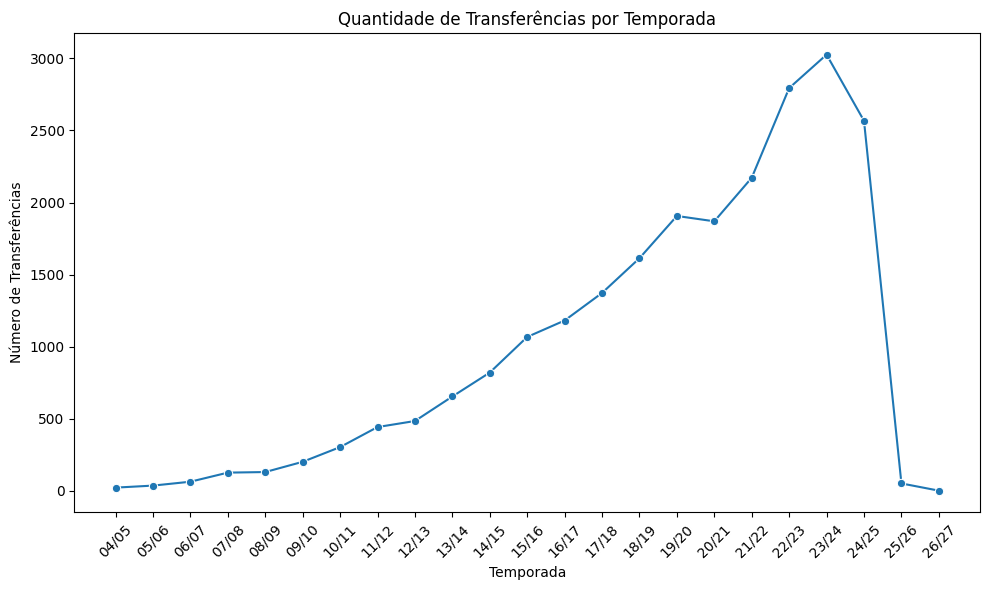

In [ ]:
df_temporadas = (
    df.groupby("transfer_season",observed=True)
      .size()
      .reset_index(name="qtd_transferencias")
)


plt.figure(figsize=(10,6))
sns.lineplot(
    data=df_temporadas,
    x="transfer_season",
    y="qtd_transferencias",
    marker="o"
)

plt.title("Quantidade de Transferências por Temporada")
plt.xlabel("Temporada")
plt.ylabel("Número de Transferências")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


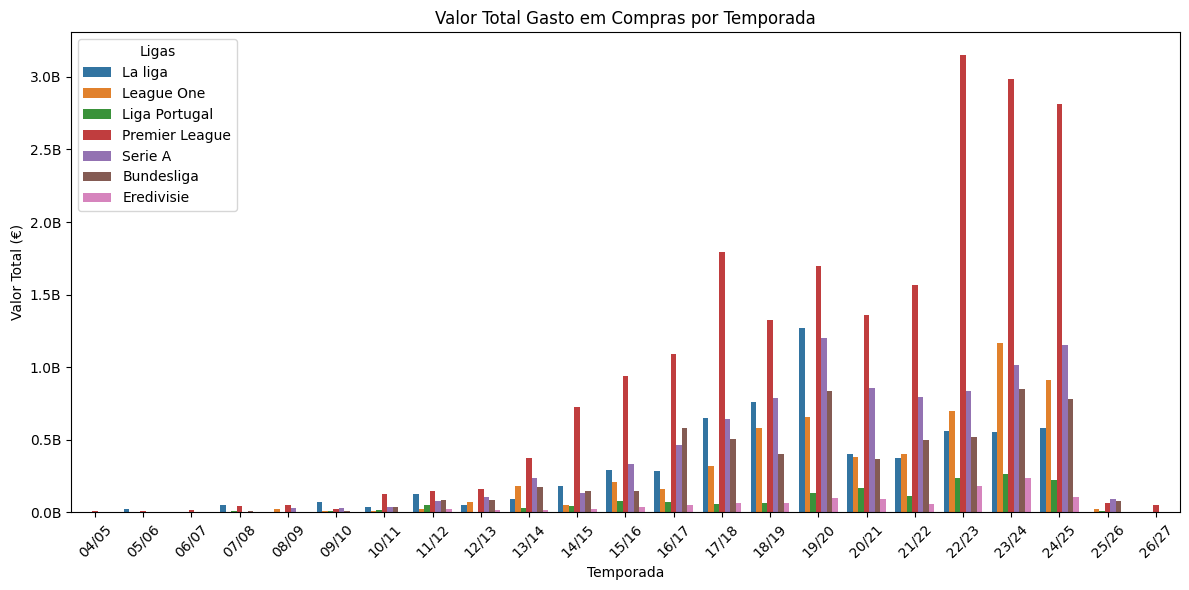

In [ ]:
df_temporadas = (
    df[df['to_league'] != 'Without league']
      .groupby(["transfer_season", "to_league"], observed=True)["transfer_fee"]
      .sum()
      .reset_index(name="valor_total")
)

plt.figure(figsize=(12,6))
sns.barplot(
    data=df_temporadas,
    x="transfer_season",
    y="valor_total",
    hue="to_league"
)

plt.title("Valor Total Gasto em Compras por Temporada")
plt.xlabel("Temporada")
plt.ylabel("Valor Total (€)")

plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1e9:.1f}B'))

plt.xticks(rotation=45)
plt.legend(title="Ligas")
plt.tight_layout()
plt.show()


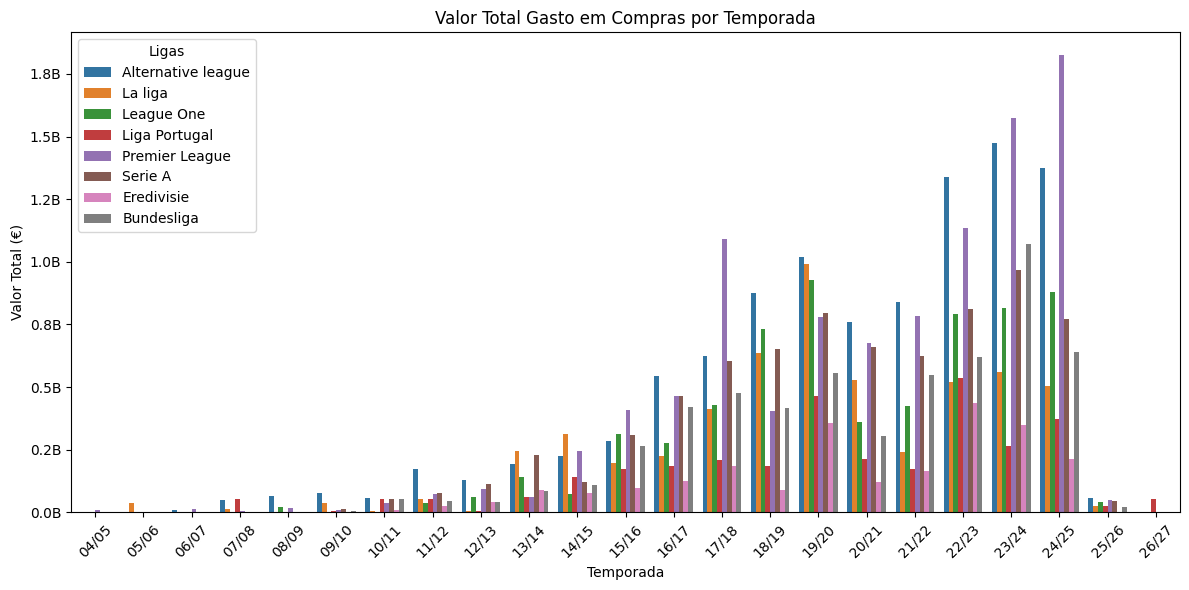

In [ ]:
df_temporadas = (
    df[df['from_league'] != 'Without league']
      .groupby(["transfer_season", "from_league"], observed=True)["transfer_fee"]
      .sum()
      .reset_index(name="valor_total")
)

plt.figure(figsize=(12,6))
sns.barplot(
    data=df_temporadas,
    x="transfer_season",
    y="valor_total",
    hue="from_league"
)

plt.title("Valor Total Gasto em Compras por Temporada")
plt.xlabel("Temporada")
plt.ylabel("Valor Total (€)")

plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1e9:.1f}B'))

plt.xticks(rotation=45)
plt.legend(title="Ligas")
plt.tight_layout()
plt.show()


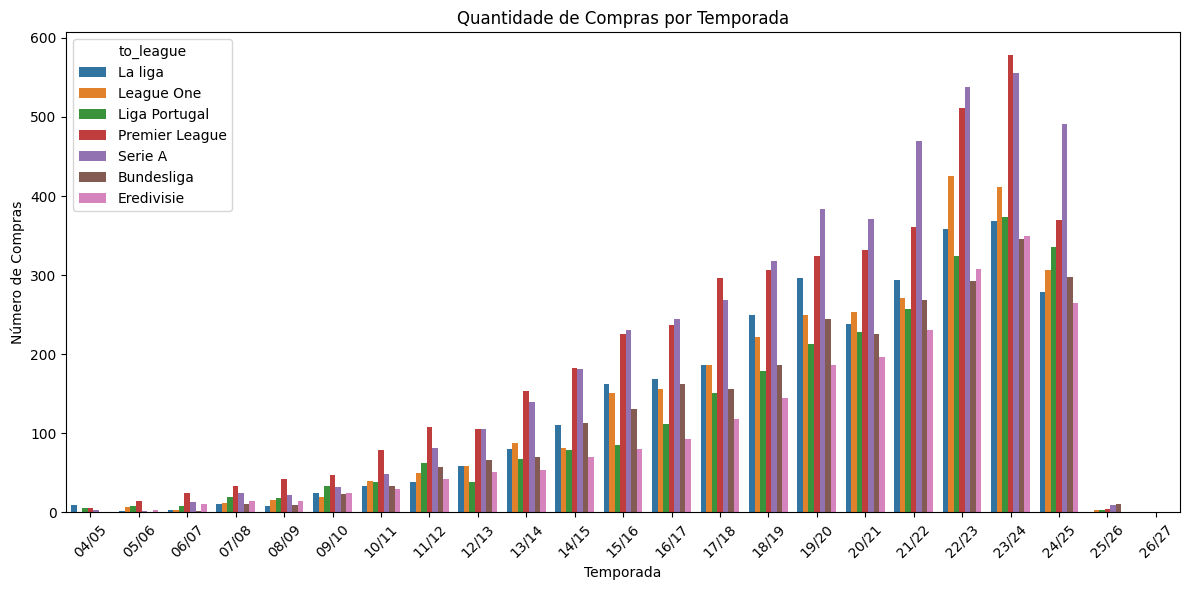

In [ ]:
df_temporadas = (
    df[df['to_league'] != 'Without league']
      .groupby(["transfer_season", "to_league"], observed=True)
      .size()
      .reset_index(name="qtd_compras")
)

plt.figure(figsize=(12,6))
sns.barplot(
    data=df_temporadas,
    x="transfer_season",
    y="qtd_compras",
    hue="to_league"
)

plt.title("Quantidade de Compras por Temporada")
plt.xlabel("Temporada")
plt.ylabel("Número de Compras")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


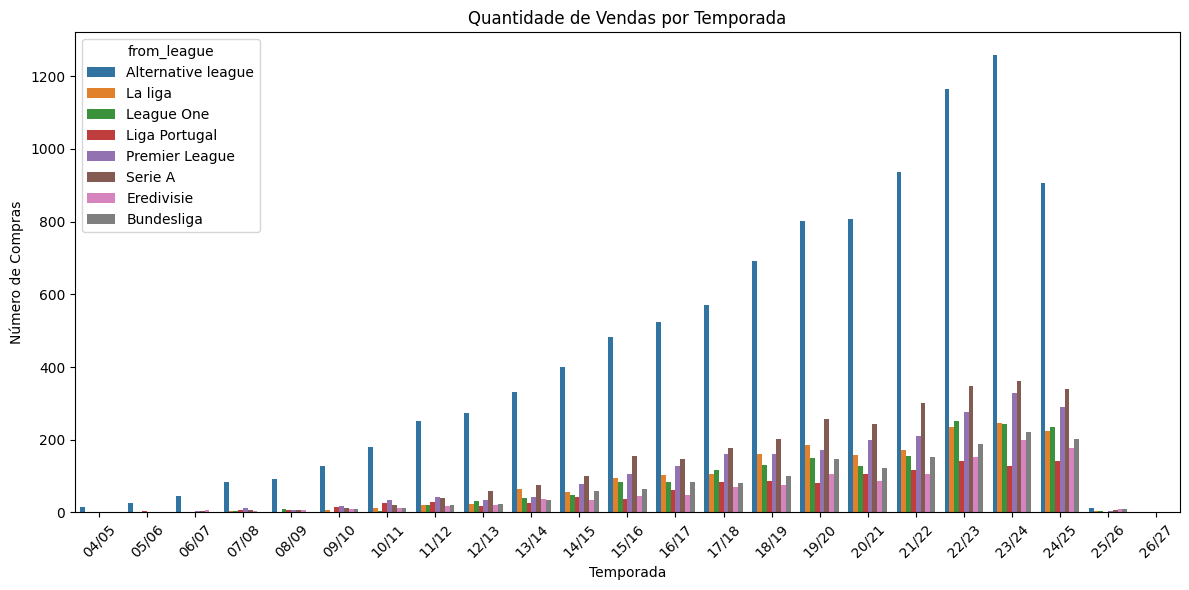

In [ ]:
df_temporadas = (
    df[df['from_league'] != 'Without league']
      .groupby(["transfer_season", "from_league"], observed=True)
      .size()
      .reset_index(name="qtd_compras")
)

plt.figure(figsize=(12,6))
sns.barplot(
    data=df_temporadas,
    x="transfer_season",
    y="qtd_compras",
    hue="from_league"
)

plt.title("Quantidade de Vendas por Temporada")
plt.xlabel("Temporada")
plt.ylabel("Número de Compras")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


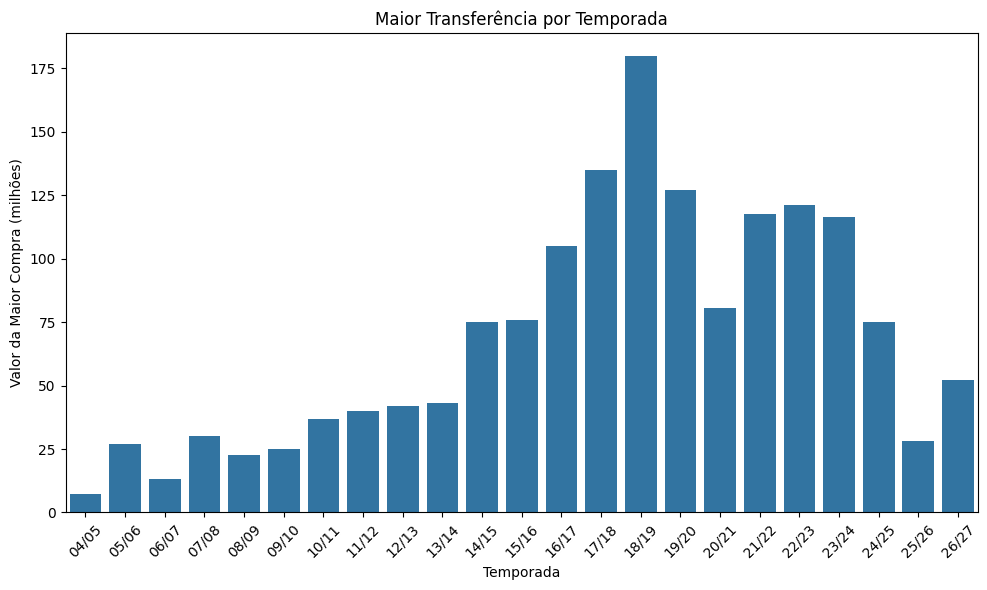

In [ ]:
temporadas_ordenadas = df['transfer_season'].sort_values().unique()
df['transfer_season'] = pd.Categorical(
    df['transfer_season'],
    categories=temporadas_ordenadas,
    ordered=True
)

df_maior = (
    df.groupby("transfer_season", observed=True)["transfer_fee"]
      .max()
      .reset_index(name="maior_compra")
)

df_maior["maior_compra"] = df_maior["maior_compra"] / 1_000_000

plt.figure(figsize=(10,6))
sns.barplot(
    data=df_maior,
    x="transfer_season",
    y="maior_compra"
)

plt.title("Maior Transferência por Temporada")
plt.xlabel("Temporada")
plt.ylabel("Valor da Maior Compra (milhões)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

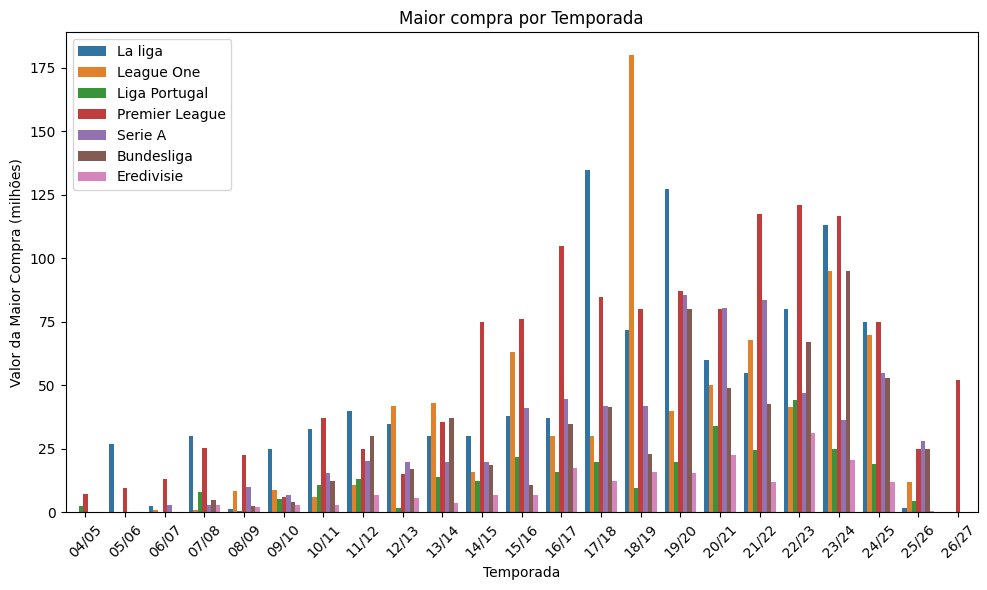

In [ ]:
temporadas_ordenadas = df['transfer_season'].sort_values().unique()
df['transfer_season'] = pd.Categorical(
    df['transfer_season'],
    categories=temporadas_ordenadas,
    ordered=True
)

df_maior = (
    df[df['to_league'] != 'Without league'].groupby(["transfer_season",'to_league'], observed=True)["transfer_fee"]
      .max()
      .reset_index(name="maior_compra")
)

df_maior["maior_compra"] = df_maior["maior_compra"] / 1_000_000

plt.figure(figsize=(10,6))
sns.barplot(
    data=df_maior,
    x="transfer_season",
    y="maior_compra",
    hue='to_league'
)

plt.title("Maior compra por Temporada")
plt.xlabel("Temporada")
plt.ylabel("Valor da Maior Compra (milhões)")
plt.xticks(rotation=45)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()


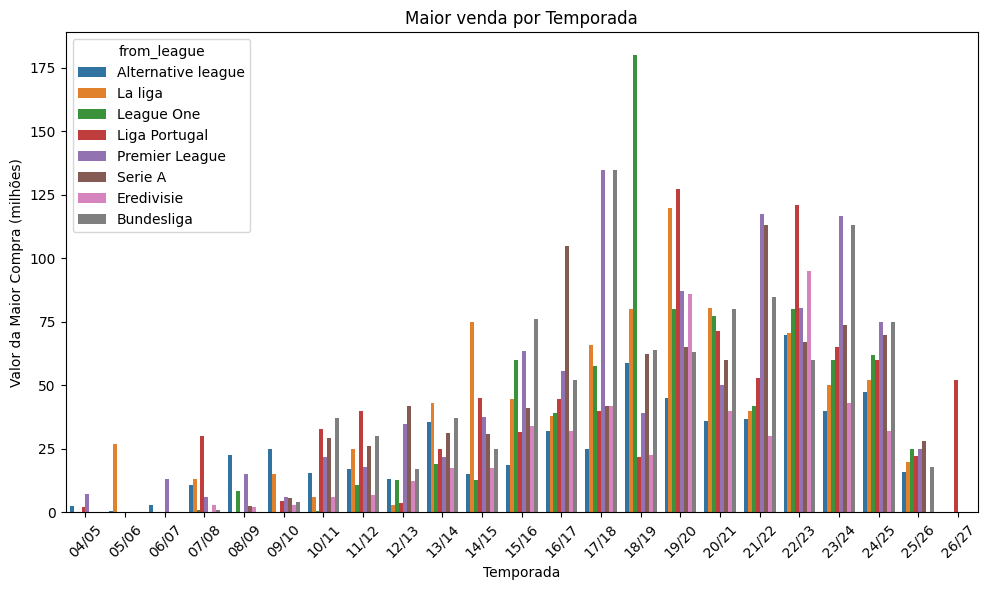

In [ ]:
temporadas_ordenadas = df['transfer_season'].sort_values().unique()
df['transfer_season'] = pd.Categorical(
    df['transfer_season'],
    categories=temporadas_ordenadas,
    ordered=True
)

df_maior = (
    df[df['from_league'] != 'Without league'].groupby(["transfer_season",'from_league'], observed=True)["transfer_fee"]
      .max()
      .reset_index(name="maior_venda")
)

df_maior["maior_venda"] = df_maior["maior_venda"] / 1_000_000

plt.figure(figsize=(10,6))
sns.barplot(
    data=df_maior,
    x="transfer_season",
    y="maior_venda",
    hue='from_league'
)

plt.title("Maior venda por Temporada")
plt.xlabel("Temporada")
plt.ylabel("Valor da Maior Compra (milhões)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#Finalizando

Criando o arquivo .csv para importar para o PowerBi

In [ ]:
df.to_csv('dadosTransferencias.csv', index=False)